In [1]:
import pandas as pd

In [399]:
planning = pd.read_excel('../dataset/a6_booster_delivery_planning.xlsx')
tracks = pd.read_excel('../dataset/ariane_tracks_booster_container_1.0.xlsx')

In [400]:
planning = pd.read_excel('../dataset/a6_booster_delivery_planning.xlsx')
tracks = pd.read_excel('../dataset/ariane_tracks_booster_container_1.0.xlsx')

tracks['Entry'] = pd.to_datetime(tracks['Entry'], format='%d.%m.%Y')
tracks['Exit'] = pd.to_datetime(tracks['Exit'], format='%d.%m.%Y')

sorted_tracks = tracks.sort_values(by=['Container','Entry'])

In [401]:
sorted_tracks = tracks.sort_values(by=['Container','Entry'])

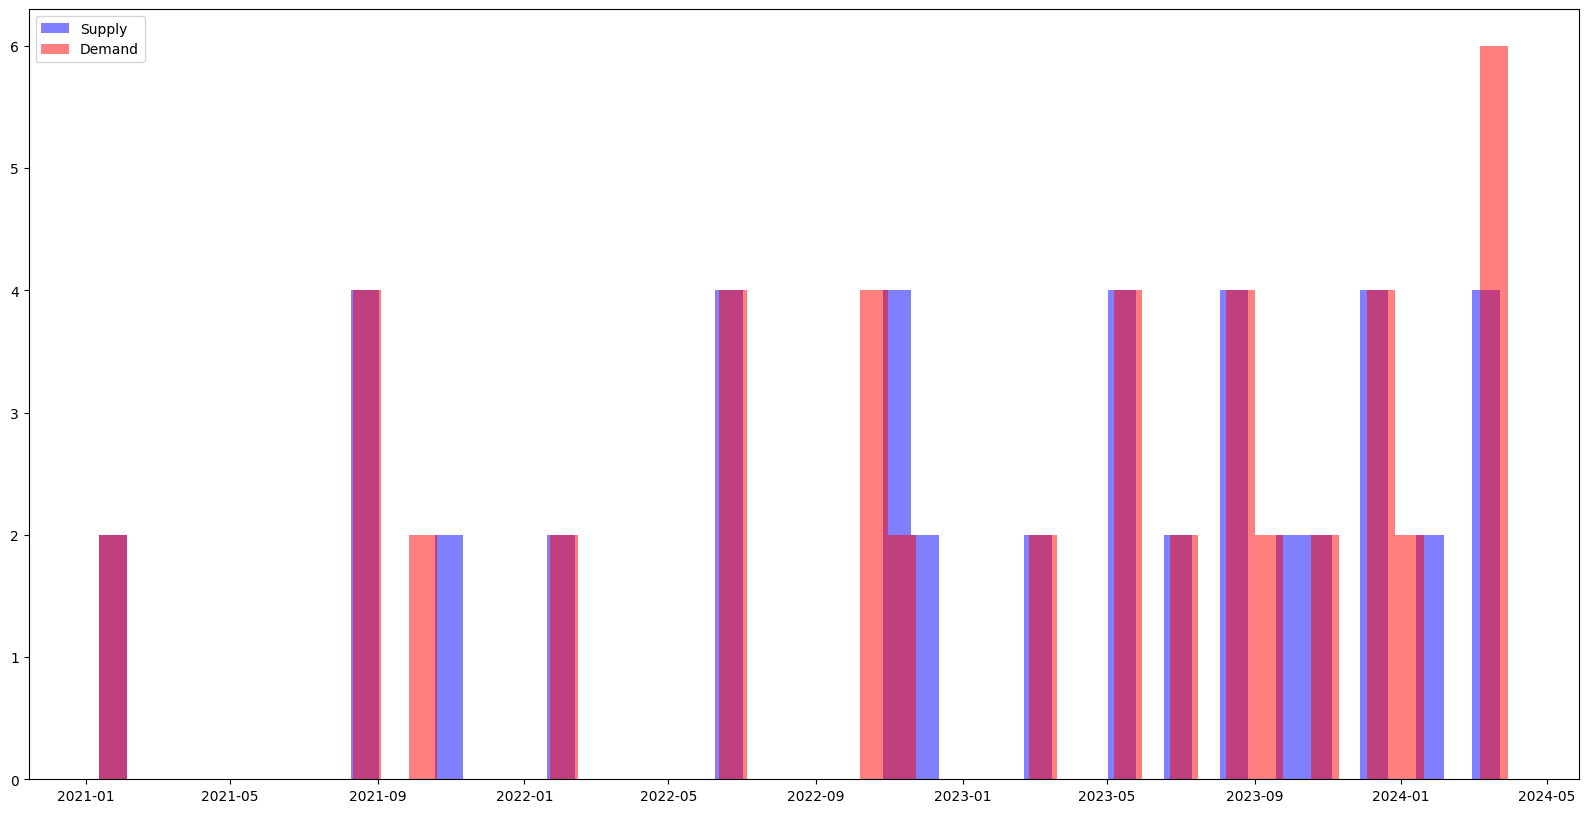

In [118]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.hist(sorted_tracks[sorted_tracks['Zone'] == 'E']['Entry'], ls='dashed', bins=50, fc=(0, 0, 1, 0.5),label='Supply')
hist2 = ax.hist(planning[planning['Date'] <= '2024-04-25']['Date'], weights=planning[planning['Date'] <= '2024-04-25']['Config'], ls='dotted', bins=50, fc=(1, 0, 0, 0.5), label='Demand')
ax.legend(prop={'size': 10})
plt.show()

In [132]:
grouped_tracks = sorted_tracks.groupby(['Zone', 'Entry'], as_index=False).count()

In [139]:
real_world = grouped_tracks[(grouped_tracks['Zone'] == 'E')][['Entry', 'Container']]

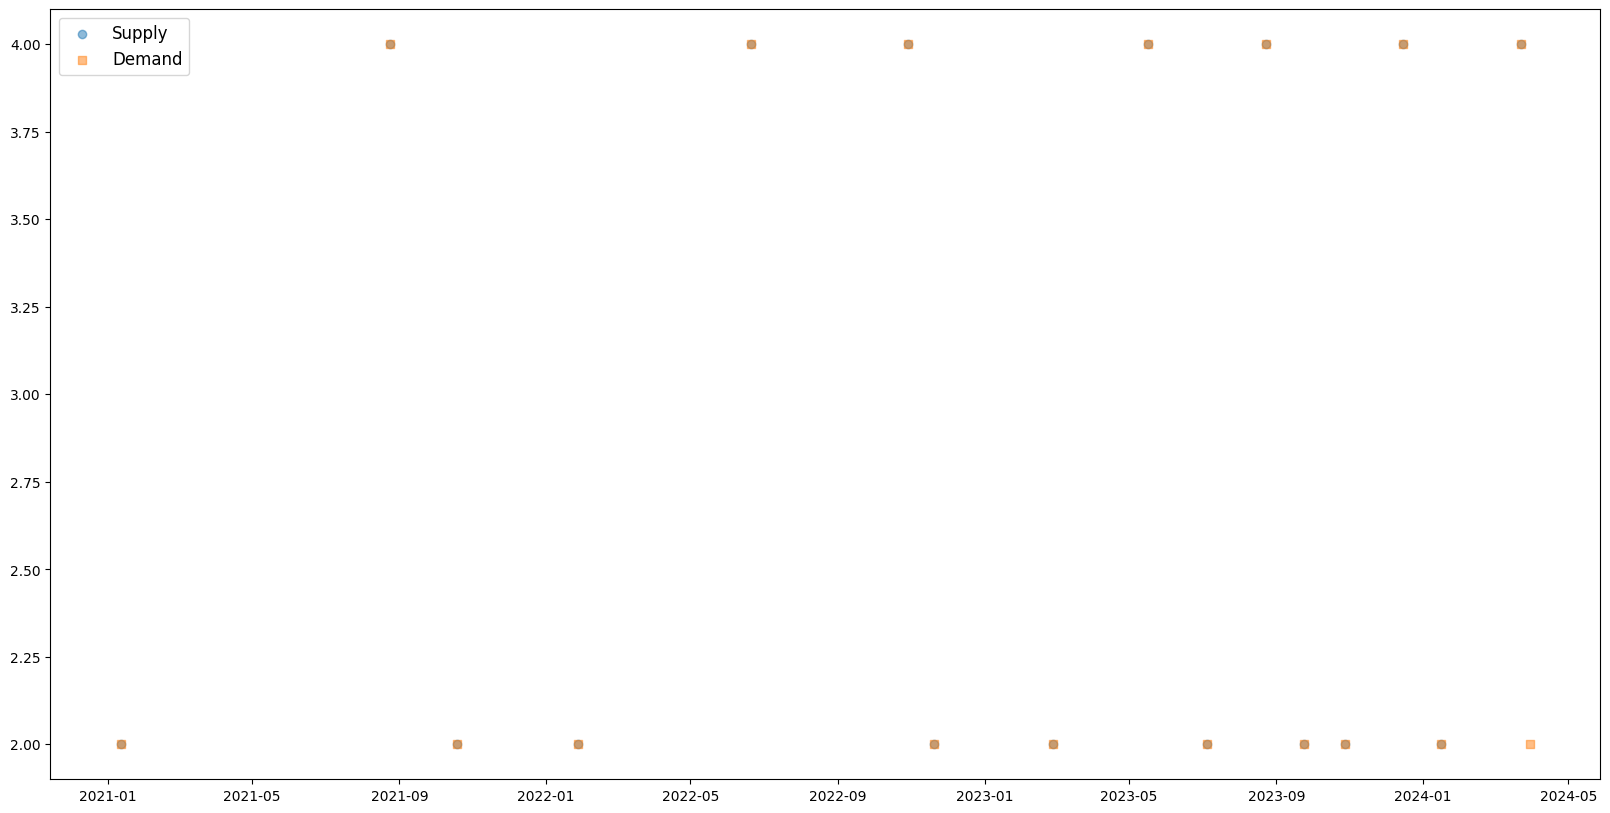

In [163]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
plt.scatter(real_world['Entry'], real_world['Container'], marker='o', label='Supply', alpha=0.5)
plt.scatter(planning[planning['Date'] <= '2024-04-25']['Date'], planning[planning['Date'] <= '2024-04-25']['Config'], marker='s', label='Demand', alpha=0.5)
ax.legend(prop={'size': 12})

In [172]:
all(planning[planning['Date'] < '2024-03-30'] == real_world.rename(columns={'Container': 'Config', 'Entry': 'Date'}).reset_index(drop=True))   

True

(array([ 2.,  8.,  4., 12., 14., 12., 16., 14., 16., 22.]),
 array([18639. , 18855.2, 19071.4, 19287.6, 19503.8, 19720. , 19936.2,
        20152.4, 20368.6, 20584.8, 20801. ]),
 <BarContainer object of 10 artists>)

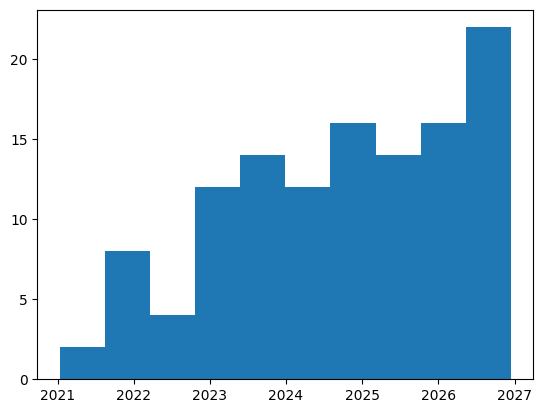

In [54]:
plt.hist(planning['Date'], weights=planning['Config'])

## Architecture

In [402]:
import pandas as pd
import numpy as np
import torch

In [403]:
planning = pd.read_excel('../dataset/a6_booster_delivery_planning.xlsx')
tracks = pd.read_excel('../dataset/ariane_tracks_booster_container_1.0.xlsx')

tracks['Entry'] = pd.to_datetime(tracks['Entry'], format='%d.%m.%Y')
tracks['Exit'] = pd.to_datetime(tracks['Exit'], format='%d.%m.%Y')

sorted_tracks = tracks.sort_values(by=['Container','Entry'])

sorted_tracks = sorted_tracks.reset_index(drop=True)
sorted_tracks['StayDays'] = sorted_tracks['Exit'] - sorted_tracks['Entry']

In [404]:
def stay_prep(sample):

    df_staying = pd.get_dummies(sample['Zone'])
    df_staying['Container'] = sample['Container']
    df_staying['Days'] = sample['StayDays']
    df_staying['AB'] = False
    df_staying['BC'] = False
    df_staying['CD'] = False
    df_staying['DE'] = False
    df_staying['ED'] = False
    df_staying['DC'] = False
    df_staying['CB'] = False
    df_staying['BA'] = False

    return df_staying

def move_prep(sample):

    sample = sample.reset_index(drop=True)

    shift = sample[1:]['Entry'].reset_index(drop=True) - sample['Exit'][:-1]
    shift.index = np.arange(1, len(shift) + 1)
    sample.loc[1:, 'TransitionTime'] = shift
    sample['Transition'] = sample['Zone'].shift(1).str.cat(sample['Zone'])
    df_moving = pd.get_dummies(sample['Transition'])
    df_moving['Container'] = sample['Container']
    df_moving['Days'] = sample['TransitionTime']
    print('Length before:', len(df_moving))
    df_moving = df_moving.dropna(subset='Days')
    print('Length after:', len(df_moving))
    df_moving['A'] = False
    df_moving['B'] = False
    df_moving['C'] = False
    df_moving['D'] = False
    df_moving['E'] = False

    return df_moving
        

In [405]:
cont_df = sorted_tracks[sorted_tracks['Container'] == 'SN2']

In [407]:
move_prep(cont_df)

Length before: 40
Length after: 39


,AB,BA,BC,CB,CD,DC,DE,ED,Container,Days,A,B,C,D,E
1,True,False,False,False,False,False,False,False,SN2,0 days,False,False,False,False,False
2,False,False,True,False,False,False,False,False,SN2,0 days,False,False,False,False,False
3,False,False,False,False,True,False,False,False,SN2,11 days,False,False,False,False,False
4,False,False,False,False,False,False,True,False,SN2,0 days,False,False,False,False,False
5,False,False,False,False,False,False,False,True,SN2,0 days,False,False,False,False,False
6,False,False,False,False,False,True,False,False,SN2,11 days,False,False,False,False,False
7,False,False,False,True,False,False,False,False,SN2,0 days,False,False,False,False,False
8,False,True,False,False,False,False,False,False,SN2,177 days,False,False,False,False,False
9,True,False,False,False,False,False,False,False,SN2,0 days,False,False,False,False,False
10,False,False,True,False,False,False,False,False,SN2,0 days,False,False,False,False,False


In [409]:
out = None

for container in sorted_tracks['Container'].unique():
    print('Doing ', container)
    cont_df = sorted_tracks[sorted_tracks['Container'] == container]
    moving = move_prep(cont_df)
    staying = stay_prep(cont_df)

    if out is None:
        out = pd.concat([moving, staying])
    else:
        out = pd.concat([out, moving, staying])

Doing  SN1
Length before: 40
Length after: 39
Doing  SN2
Length before: 40
Length after: 39
Doing  SN3
Length before: 39
Length after: 38
Doing  SN4
Length before: 40
Length after: 39
Doing  SN5
Length before: 17
Length after: 16
Doing  SN6
Length before: 56
Length after: 55
Doing  SN7
Length before: 72
Length after: 71
Doing  SN8
Length before: 64
Length after: 63


In [410]:
out

,AB,BA,BC,CB,CD,DC,DE,ED,Container,Days,A,B,C,D,E,CA
1,True,False,False,False,False,False,False,False,SN1,0 days,False,False,False,False,False,NaN
2,False,False,True,False,False,False,False,False,SN1,0 days,False,False,False,False,False,NaN
3,False,False,False,False,True,False,False,False,SN1,11 days,False,False,False,False,False,NaN
4,False,False,False,False,False,False,True,False,SN1,0 days,False,False,False,False,False,NaN
5,False,False,False,False,False,False,False,True,SN1,0 days,False,False,False,False,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,False,False,False,False,False,False,False,False,SN8,2 days,False,False,False,True,False,NaN
364,False,False,False,False,False,False,False,False,SN8,15 days,False,False,False,False,True,NaN
365,False,False,False,False,False,False,False,False,SN8,2 days,False,False,False,True,False,NaN
366,False,False,False,False,False,False,False,False,SN8,1 days,False,False,True,False,False,NaN


#### CA is above because of the errors in the data; should add a preprocessing